In [1]:
using ForwardDiff
using DiffEqSensitivity, OrdinaryDiffEq, Zygote
include("/Users/piotrsokol/Documents/RNNODE.jl/src/layers.jl")
using Plots
import LinearAlgebra:norm
using NPZ

In [2]:
global tmax = 100.
global reltol = 1e-8
global abstol = 1e-8

1.0e-8

In [22]:
function get_forward(rnn, u0; alg=Vern9())
    p,re = Flux.destructure(rnn)
    function f(du,u,p,t)
    du.= re(p)(u,zeros(1))
    end

prob = ODEProblem(f,u0,(0.0,tmax),p)
if isa(alg,Euler)
    sol = solve(prob,alg,abstol=1e-10,reltol=reltol, adaptive=false,dt = 1.,)
else
    sol = solve(prob,alg,abstol=1e-10,reltol=abstol,saveat=collect(0.0:0.1:tmax), dt = 1.)
end
end

get_forward (generic function with 1 method)

In [23]:
function get_adjoint(sol;alg=Vern9(), firstn = 2)
    checkpoints=sol.t

    last_i = length(sol)
    dg(out,u,p,t,i) = (i==last_i ? randn!(out)/sqrt(length(u)) : out.=zeros(eltype(out),size(out)) )
    tsops = checkpoints    


    
    if isa(alg,Euler)
        sensealg=InterpolatingAdjoint(checkpointing=true)

        adj_prob = ODEAdjointProblem(sol,sensealg,dg,sol.t,dg=nothing,checkpoints=sol.t,
                                    abstol=abstol,reltol=reltol)
        adj_sol = solve(adj_prob,alg; save_everystep=true, abstol=abstol, reltol=reltol,adaptive=false)
    else
        sensealg=InterpolatingAdjoint(checkpointing=true)

        adj_prob = ODEAdjointProblem(sol,sensealg,dg,sol.t,dg=nothing,checkpoints=sol.t,
                                    abstol=abstol,reltol=reltol)
        adj_sol = solve(adj_prob,alg; save_everystep=false, abstol=abstol, reltol=reltol, saveat=sol.t)
    end
    if firstn == -1
        idx =length(sol.prob.u0)
    else
        idx = firstn
    return adj_sol.t, permutedims(Array(adj_sol)[1:idx,:])
    end
end

get_adjoint (generic function with 1 method)

In [24]:
hsize = 2
rnn = ∂RNNCell(1,hsize);
u0 = rand(hsize);

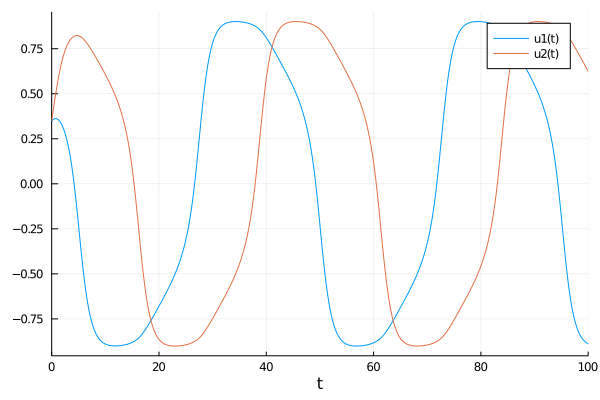

In [25]:
sol = get_forward(rnn, u0);
plot(sol)

In [26]:
ts1, adj_rnn1 = get_adjoint(sol, firstn = 2);
ts2, adj_rnn2 = get_adjoint(sol, firstn = 2);


In [27]:
npzwrite("limitcycle_adj_other.npz", Dict("time_adj" => ts1, "adj1"=> reverse(adj_rnn1,dims=1), "adj2"=> reverse(adj_rnn2,dims=1), "time_fwd"=>sol.t, "fwd"=> Array(sol) ) )

### EoC init

In [30]:
hsize = 2
factor = 1.f0
initW(dims...) = sqrt(factor) * randn(Float32, dims...)/Float32(sqrt(dims[1]))
rnn = ∂RNNCell(1,hsize,σ = tanh, initWᵢ = Flux.zeros, initWᵣ=initW, initb = Flux.zeros)
u0 = rand(Float32, hsize);

In [31]:
sol = get_forward(rnn, u0);

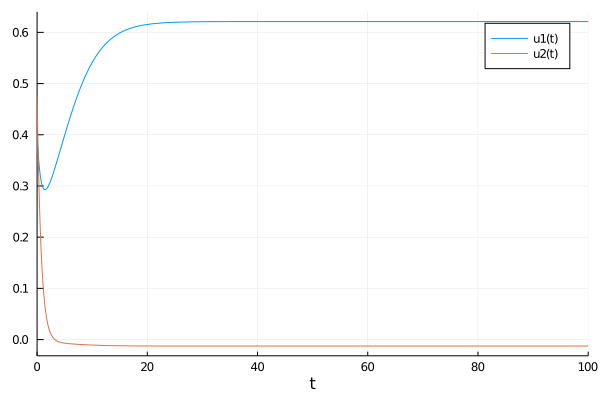

In [32]:
plot(sol)

In [33]:
ts1, adj_rnn1 = get_adjoint(sol, firstn = 2);
ts2, adj_rnn2 = get_adjoint(sol, firstn = 2);
npzwrite("eoc_adj.npz", Dict("t1" => ts1, "t2" => ts2, "tfwd" => sol.t, "adjsol1"=> adj_rnn1, "adjsol2"=> adj_rnn2, "fwdsol"=> Array(sol) ) )

LoadError: MethodError: Cannot `convert` an object of type 
  ODESolution{Float32,2,Array{Array{Float32,1},1},Nothing{},Nothing{},Array{Float64{},1},Array{Array{Array{Float32,1},1},1},ODEProblem{Array{Float32,1},Tuple{Float64{},Float64{}},true,Array{Float32{},1},ODEFunction{true,var"#f#62"{Flux.var"#34#36"{∂RNNCell{typeof(tanh){},Array{Float32{},2},Array{Float32{},1}}}},LinearAlgebra.UniformScaling{Bool{}},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{}},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem{}},Vern9{},OrdinaryDiffEq.InterpolationData{ODEFunction{true,var"#f#62"{Flux.var"#34#36"{∂RNNCell{typeof(tanh){},Array{Float32{},2},Array{Float32{},1}}}},LinearAlgebra.UniformScaling{Bool{}},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{}},Array{Array{Float32,1},1},Array{Float64{},1},Array{Array{Array{Float32,1},1},1},OrdinaryDiffEq.Vern9Cache{Array{Float32,1},Array{Float32,1},Array{Float32,1},OrdinaryDiffEq.Vern9Tableau{Float32,Float64{}}}},DiffEqBase.DEStats{}} to an object of type 
  ODESolution{Float64,2,Array{Array{Float64,1},1},Nothing{},Nothing{},Array{Float64{},1},Array{Array{Array{Float64,1},1},1},ODEProblem{Array{Float64,1},Tuple{Float64{},Float64{}},true,Array{Float32{},1},ODEFunction{true,var"#f#62"{Flux.var"#34#36"{∂RNNCell{typeof(tanh){},Array{Float32{},2},Array{Float32{},1}}}},LinearAlgebra.UniformScaling{Bool{}},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{}},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem{}},Vern9{},OrdinaryDiffEq.InterpolationData{ODEFunction{true,var"#f#62"{Flux.var"#34#36"{∂RNNCell{typeof(tanh){},Array{Float32{},2},Array{Float32{},1}}}},LinearAlgebra.UniformScaling{Bool{}},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{},Nothing{}},Array{Array{Float64,1},1},Array{Float64{},1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.Vern9Cache{Array{Float64,1},Array{Float64,1},Array{Float64,1},OrdinaryDiffEq.Vern9Tableau{Float64,Float64{}}}},DiffEqBase.DEStats{}}
Closest candidates are:
  convert(::Type{T}, !Matched::T) where T<:AbstractArray at abstractarray.jl:14
  convert(::Type{T}, !Matched::LinearAlgebra.Factorization) where T<:AbstractArray at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/factorization.jl:55
  convert(::Type{T}, !Matched::T) where T at essentials.jl:171
  ...

In [ ]:
plot(ts1, adj_rnn1)